# Introduction

Recognizing traffic signs from real-time video streams from smart vehicles is one of the demanding solutions in today's automobile industry. It became a demanding solution in autonomous vehicles, driver assistance systems and mobile mapping. The Traffic Sign Recognition (TSR) challenge consists two components 1) traffic sign detection and traffic sign classification. Traffic sign detection is the activity of accurate localizing the traffic sign in an image, while traffic sign classification assigns a label (symbol name/details) to the localized picture. Recent developments in Deep Learning and publically available data sets such as Belgium and German Traffic Sign Data accelerated many innovations in this field. The objective of the current project is to build a traffic sign classification system with the German Traffic Signs dataset. 

## Exploratory Data Analysis

The dataset is supplied as Python pickled objects. The training, validation and test data are in the same format. Each picked object contains the following information: 'labels', 'coords', 'sizes', 'features'. The 'features' contain the image pixel data, 'coords' contains localization information, 'size' contains image size and the  'labels' contains a numeric value representing the traffic sign represented in the image. The train, test and valid data consist 34799, 12630, 4410 samples respectively. There are 43 traffic signs in this image data sets, and it translates to 43 labels in the data sets.

In [1]:
%matplotlib inline
from matplotlib import pylab as plt
import seaborn as sn
plt.rcParams['figure.figsize'] = (9,4)

In [2]:
import glob
import pickle
import random

import numpy as np
import pandas as pd
from skimage import exposure
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn import metrics

### Reading the Data

In [3]:
data_files = glob.glob("data/*.p")

In [4]:
train = None
test = None
valid = None

for fname in data_files:
    with open(fname,mode='rb') as pf:
        if fname.endswith("test.p"):
            test = pickle.load(pf)
        elif fname.endswith("train.p"):
            train = pickle.load(pf)
        elif fname.endswith("valid.p"):
            valid = pickle.load(pf)

#### Total records in Train Test and Valid Sets

In [5]:
len(train["features"]),len(test["features"]),len(valid["features"])

(34799, 12630, 4410)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


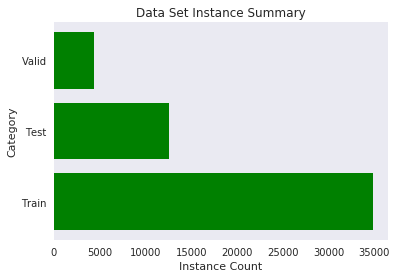

In [6]:
lbls = ("Train","Test","Valid")
y_pos = np.arange(len(lbls))
data_set_size = {0:34799,1:12630,2:4410}

plt.figure(figsize=(6,4))
plt.barh(y_pos, list(data_set_size.values()), align='center', alpha=1,color='g')
plt.yticks(y_pos, lbls)
plt.xlabel('Instance Count')
plt.ylabel('Category')
plt.title('Data Set Instance Summary')
plt.grid(False)
plt.show()

In [7]:
unique, counts = np.unique(train["sizes"], return_counts=True)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


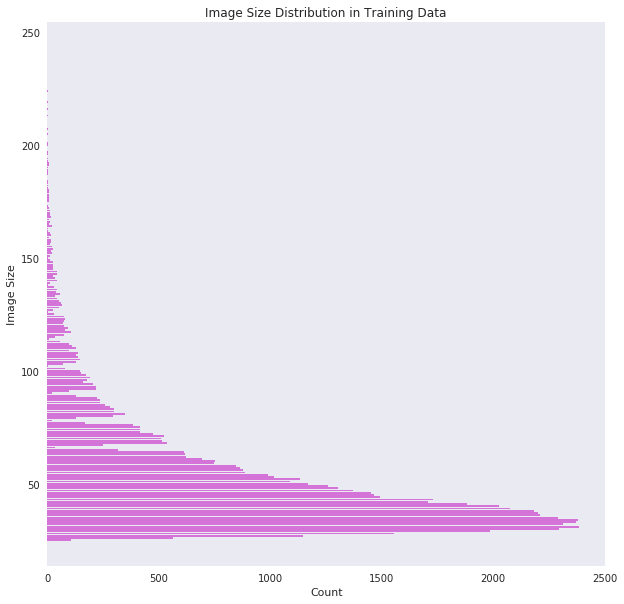

In [8]:
plt.figure(figsize=(10,10))
plt.barh(unique, counts, align='center', alpha=0.5,color='m')
#plt.yticks(y_pos, lbls)
plt.xlabel('Count')
plt.ylabel('Image Size')
plt.title('Image Size Distribution in Training Data')
plt.grid(False)
plt.show()

### Class Distribution Analysis in the Data
An analysis of the class distribution in training data suggests that it is a highly imbalanced dataset. The well-represented class consists samples in the range of 1000 to 2500 and the under-represented classed consists instances in the range of 120 to 850. In general Machine Learning scenarios, the under-represented or imbalanced class distribution is not an ideal situation to start with any Machine Learning experiment. So it is recommended to perform either additional data collection or perform an oversampling or undersampling of the data. Oversampling of data is a typical strategy for the same. 

In [9]:
train_df = pd.Series(train['labels'])
train_label_count = train_df.value_counts()
test_df = pd.Series(test['labels'])
test_label_count = test_df.value_counts()
valid_df = pd.Series(valid['labels'])
valid_label_count = valid_df.value_counts()

In [10]:
train_label_count_df = pd.DataFrame()
train_label_count_df["ClassId"] = train_label_count.index
train_label_count_df["Count"] = train_label_count.values
label_map = pd.read_csv("signnames.csv")
train_joined_labels = pd.merge(train_label_count_df,label_map,on='ClassId')

In [11]:
sign_label_map = dict(zip(train_joined_labels.ClassId,train_joined_labels.SignName))

In [12]:
len(sign_label_map)

43

In [13]:
image_samples =[np.where(train["labels"]==i)[0][0] for i, x in enumerate(np.unique(train["labels"]))]

In [14]:
samples = [train["features"][img_indx] for indx,img_indx in enumerate(image_samples)]

In [15]:
def plot_one_sample(samples):
    fig = plt.figure(figsize=(9, 9))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(len(samples)):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(samples[i].squeeze())
    plt.show()

###### Sample Image from all the categories

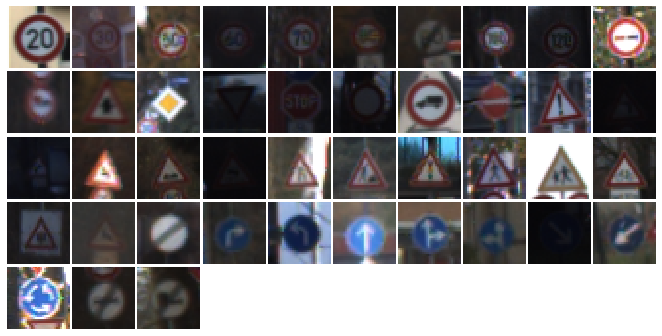

In [16]:
plot_one_sample(samples)

In [17]:
def plot_class_dict(train_label_count,color):

    train_label_count_df = pd.DataFrame()
    train_label_count_df["ClassId"] = train_label_count.index
    train_label_count_df["Count"] = train_label_count.values
    label_map = pd.read_csv("signnames.csv")
    train_joined_labels = pd.merge(train_label_count_df,label_map,on='ClassId')
    train_joined_labels.index = train_joined_labels.ClassId
    sbp = sn.barplot(x="SignName",y="Count",data=train_joined_labels,color=color)
    d = plt.setp(sbp.get_xticklabels(), rotation=90)
    plt.ylabel("Count")
    plt.show()

###### Training Data Class Distribution

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


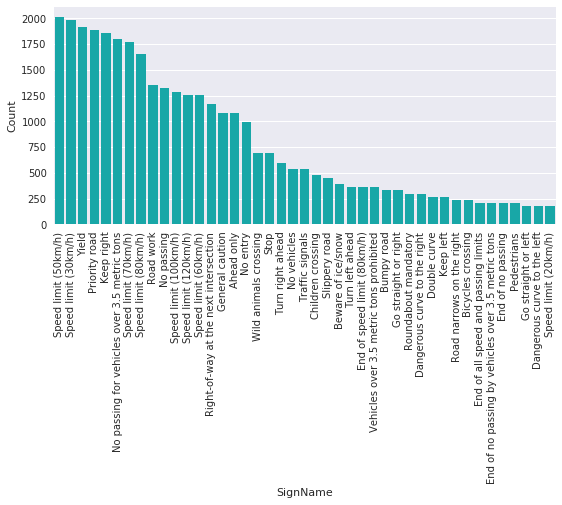

In [18]:
plot_class_dict(train_label_count,"c")

###### Test Data Class Distribution

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


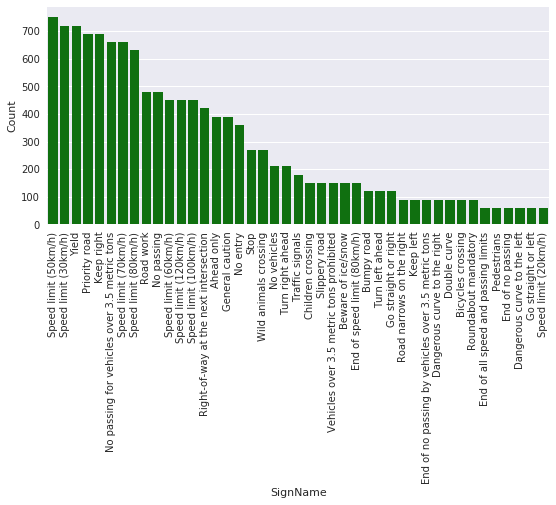

In [19]:
plot_class_dict(test_label_count,"g")

###### Validation Data Class Distribution

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


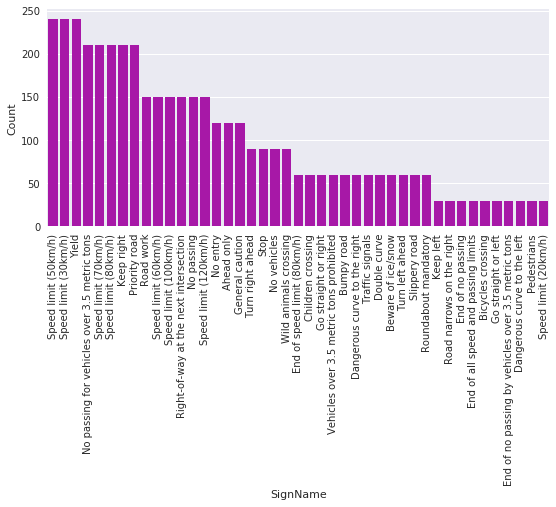

In [20]:
plot_class_dict(valid_label_count,"m")

### Synthetic Data Generation
The additional data generation to overcome the imbalanced data is performed with Keras library. Keras provided image augmentation API with a comprehensive set of parameters to satisfy different experiment purposes. The settings used in the current projects includes
* featurewise_center: Set input mean to 0 over the dataset, feature-wise.
* rotation_range:  Degree range for random rotations. The rotation range was specified as 17 for the augmentation.
* width_shift_range: Range for random horizontal shifts. Specified value 0.1
*  height_shift_range: Range for random vertical shifts. Specified value 0.1
* shear_range:  Shear Intensity (Shear angle in the counter-clockwise direction as radians). Specified Value: 0.3
* zoom_range: Range for random zoom. Specified Value: 0.15
* horizontal_flip:  Randomly flip inputs horizontally. Not performed 


In [21]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


augumentar = ImageDataGenerator(rotation_range=17,width_shift_range=0.1,\
height_shift_range=0.1,shear_range=0.3,zoom_range=0.15,horizontal_flip=False,\
fill_mode='nearest',featurewise_center=True)
#fill_mode='nearest',featurewise_center=True,zca_whitening=True)

def image_aug(X,y):
    """
    Apply image Augumentation with Keras
    """
    X_aug = None
    y_aug = None
    #augumentar.fit(X)
    for X_batch, y_batch in augumentar.flow(X, y, batch_size=X.shape[0], shuffle=False):
        X_aug = X_batch.astype('uint8')
        y_aug = y_batch
        break
    return (X_aug,y_aug)

Using TensorFlow backend.


In [22]:
augm_images = image_aug(train["features"],train["labels"])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


###### A Sample Augumented Image

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


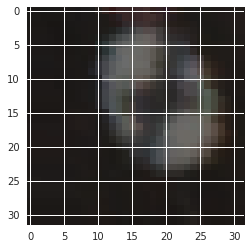

In [23]:
plt.imshow(augm_images[0][1].squeeze())

In [24]:
X_train_augumented = augm_images[0]
Y_train_augumented = augm_images[1]

###### Augumented Image sample from 43 categories

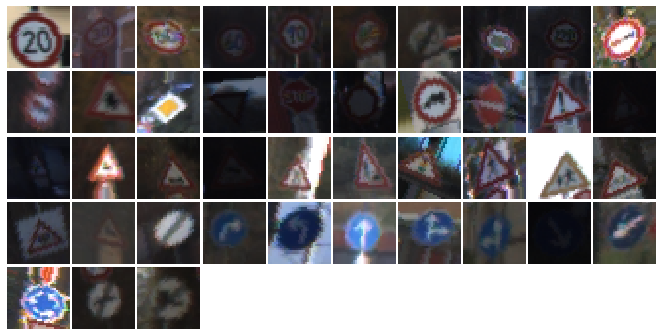

In [25]:
aug_samplees = [X_train_augumented[img_indx] for indx,img_indx in enumerate(image_samples)]
plot_one_sample(aug_samplees)

#### Motion Blur 

The additional image data generation step adopted in this project is Motion Blur. Motion blur is the apparent streaking of rapidly moving objects in a still image. It helps the traffic sign classifier to almost accurately classify a localized sign to the proper category. In real-time image processing, this techniques is a very useful approach. 

In [26]:
def mblur(X):
    """
    Create a motion blur
    """
    X_out = np.empty((X.shape)).astype('uint8')
    size = 4
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    for idx, img in enumerate(X):
        X_out[idx] = cv2.filter2D(img, -1, kernel_motion_blur)
    return X_out

In [27]:
X_train_motion_blur = mblur(train["features"])
y_train_motion_blur = train["labels"]

###### Sample Results of Motion Blur

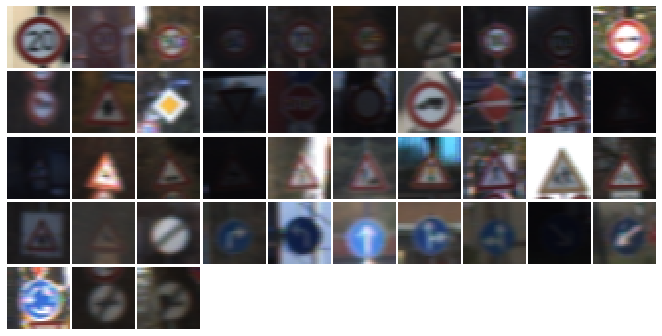

In [28]:
mb_samplees = [X_train_motion_blur[img_indx] for indx,img_indx in enumerate(image_samples)]

plot_one_sample(mb_samplees)

#### Preprocessing 
In this project, we preprocessed the images before it is being presented to the algorithm for model building. The preprocessing steps adopted in the projects are normalizing the exposure and converting the images to grayscale. This steps will help us preventing some of the adversarial scenarios, such as negative images are not getting classified correctly. Recent researched in the images processing, and Deep Learning reveals that negatives images will be a challenging one for many models. 

In [29]:
def process_image(img):
    img_c = cv2.cvtColor(img, (cv2.COLOR_BGR2YUV))[:,:,0]
    img_c = (img_c / 255.).astype(np.float32)
    img_c = (exposure.equalize_adapthist(img_c,) - 0.5)
    img_c = img_c.reshape(img_c.shape + (1,))
    return img_c

def preprocess_data(X):
    X_processed = np.empty((X.shape[0],X.shape[1],X.shape[2],1)).astype(np.float32) 
    for idx, img in enumerate(X):
        X_processed[idx] = process_image(img)
    return X_processed

In [30]:
X_train_raw_p = preprocess_data(train["features"])
y_train_raw_p = train["labels"]
X_train_aug_p = preprocess_data(X_train_augumented)
y_train_aug_p = Y_train_augumented
X_train_mb_p = preprocess_data(X_train_motion_blur)
y_train_mb_p = y_train_motion_blur

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [31]:
X_test_raw_p = preprocess_data(test["features"])
y_test_raw_p = test["labels"]

X_valid_raw_p = preprocess_data(valid["features"])
y_valid_raw_p = valid["labels"]

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))


#### Preprocessed Raw Training Data Samples

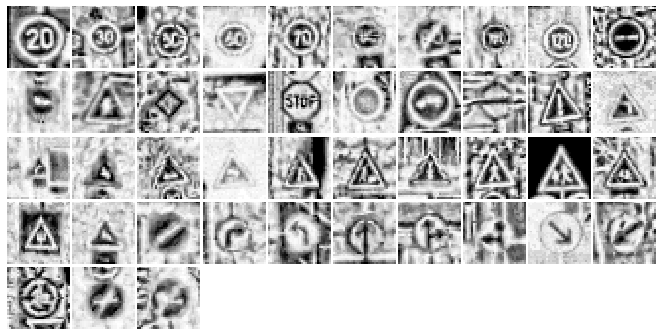

In [32]:
mb_samplees = [X_train_raw_p[img_indx] for indx,img_indx in enumerate(image_samples)]

plot_one_sample(mb_samplees)

##### Preprocessed Augumented Data

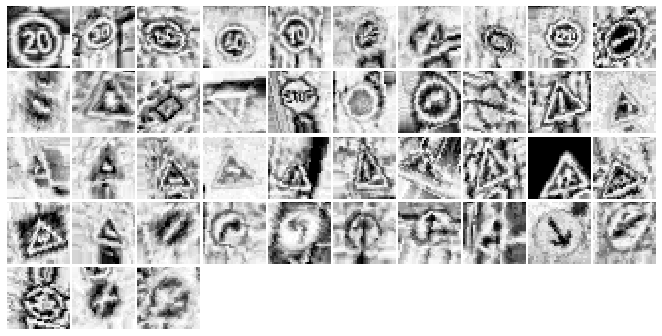

In [33]:
mb_samplees = [X_train_aug_p[img_indx] for indx,img_indx in enumerate(image_samples)]

plot_one_sample(mb_samplees)

In [34]:
X_train = np.concatenate((X_train_raw_p,X_train_aug_p,X_train_mb_p), axis=0)
y_train = np.concatenate((y_train_raw_p,y_train_aug_p,y_train_mb_p), axis=0)

In [35]:
X_train, y_train = shuffle(X_train, y_train)

#### Onehot Encoding of Labels for Training

In [36]:
from keras.utils import to_categorical
y_oh_train = to_categorical(y_train, num_classes=43)
y_oh_valid = to_categorical(y_valid_raw_p, num_classes=43)
y_test_raw_p_oh = to_categorical(y_test_raw_p, num_classes=43)

### Utilities to Visualize the Model Results
Plot training accuracy and loss

In [37]:
def plot_acc_loss(model_history):
    """
    Plot the Training and validation accuracy and loss
    Param : Model training history
    """
    f, axarr = plt.subplots(2, sharex=True)
    axarr[0].plot(model_history.history["acc"])
    axarr[0].plot(model_history.history["val_acc"])
    axarr[0].set_title('model accuracy')
    axarr[0].set_ylabel('accuracy')
    axarr[0].set_xlabel('epoch')
    axarr[0].legend(['train', 'test'], loc='upper left')
    #axarr[1].scatter(x, y)
    axarr[1].plot(model_history.history["loss"])
    axarr[1].plot(model_history.history["val_loss"])
    axarr[1].set_title('model loss')
    axarr[1].set_ylabel('loss')
    axarr[1].set_xlabel('epoch')
    axarr[1].legend(['train', 'test'], loc='best')
    plt.show()

Get precision,recall,f1-score and confusion matrix

In [38]:
from sklearn import metrics
     
def get_metrics_cm(y_true,y_pred):
    """
    Get precision,recall F1 score and plot COnfusion Matrix
    #WArning
    First apply the predict function and then use np.argma for getting
    the label.
    Use the raw ylabel not one hot encoded
    l3_predict = lenet3.predict(X_test_raw_p)
    l3_predict = np.argmax(l3_predict, axis=1)
    """
    #y_true = y_test_raw_p
    sn.set(font_scale=1.4)
    #sn.set_context("paper", rc={"font.size":5,"axes.titlesize":5,"axes.labelsize":5})  
    print ("Precision", metrics.precision_score(y_true, y_pred, average='macro'))
    print ("Recall", metrics.recall_score(y_true, y_pred, average='micro'))
    print ("f1_score", metrics.f1_score(y_true, y_pred, average='weighted'))
    print ("Confusion_matrix")
    cm = metrics.confusion_matrix(y_true, y_pred)

    plt.figure(figsize = (6,6))
    #sn.set(font_scale=1.4)
    sn.heatmap(cm,annot=False,annot_kws={"size": 8})

Plot the ROC Curve

In [39]:
from sklearn.metrics import roc_curve, auc


def plot_roc(y_test,y_pred,nc):
    """
    Plot a multi class ROC Curve
    Onehot Y
    Result of predict 
    Number of classes 43
    """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(43):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
    for i in range(nc):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    #plt.legend(loc="best")
    plt.show()

## Model

In [40]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.utils import to_categorical

from keras import backend as K

In [48]:
lenet = Sequential()
lenet.add(Convolution2D(32,kernel_size=(5,5),padding="valid",strides=(1, 1),input_shape=(32,32,1),\
name="conv11",data_format="channels_last"))
lenet.add(Activation("relu",name="eye1"))
lenet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
lenet.add(Dropout(0.1))

lenet.add(Convolution2D(32,kernel_size=(5,5),padding="valid",strides=(1,1),name="conv2"))
lenet.add(Activation("relu",name="eye2"))
lenet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid"))
lenet.add(Dropout(0.2))

lenet.add(Convolution2D(32,kernel_size=(5,5),padding="valid",strides=(1,1),name="conv3"))
lenet.add(Activation("relu",name="eye3"))
lenet.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1),padding="valid"))
lenet.add(Dropout(0.3))

lenet.add(Convolution2D(16,kernel_size=(1,1),padding="valid",strides=(1,1),name="conv4"))
lenet.add(Activation("relu",name="eye4"))
lenet.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1),padding="valid"))
lenet.add(Dropout(0.4))

lenet.add(Flatten())
lenet.add(Dense(600))
lenet.add(Activation("relu",name="eye5"))
lenet.add(Dropout(0.5))


lenet.add(Dense(len(np.unique(y_train))))
lenet.add(Activation("softmax",name="visual"))
lenet.add(Dropout(0.6))

opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
lenet.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [49]:
lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv11 (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
eye1 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 32)        25632     
_________________________________________________________________
eye2 (Activation)            (None, 10, 10, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 5, 5, 32)          0         
__________

In [50]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto')

### Model Evaluation

In [51]:
lenet_model_hist = lenet.fit(X_train,y_oh_train,batch_size=128,epochs=20,\
verbose=1,validation_data=(X_valid_raw_p,y_oh_valid),\
callbacks=[es])

Train on 104397 samples, validate on 4410 samples
Epoch 1/20
104397/104397 [==============================] - 92s - loss: 10.4027 - acc: 0.1365 - val_loss: 1.7208 - val_acc: 0.4358

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


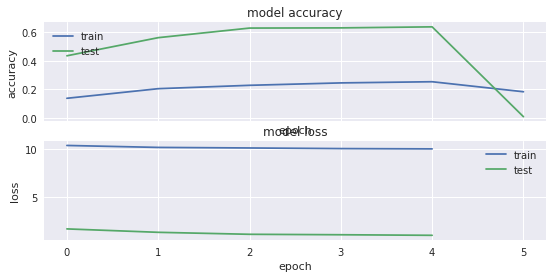

In [52]:
plot_acc_loss(lenet_model_hist)

In [53]:
lenet_score = lenet.evaluate(X_test_raw_p, y_test_raw_p_oh, verbose=1)
lenet_score

12608/12630 [============================>.] - ETA: 0s

[nan, 0.0047505938265876742]

In [54]:
lenet_test_pred = lenet.predict(X_test_raw_p)
lenet_test_pred_lbls = np.argmax(lenet_test_pred, axis=1)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision 0.000110478926145
Recall 0.00475059382423
f1_score 4.49228730423e-05
Confusion_matrix


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


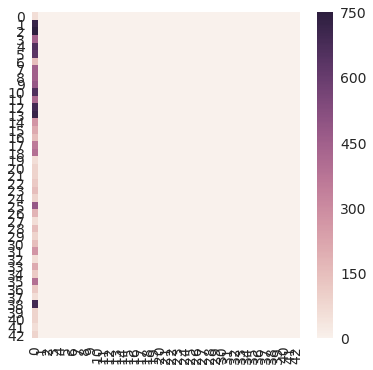

In [55]:
get_metrics_cm(y_test_raw_p,lenet_test_pred_lbls)

In [57]:
#plot_roc(y_test_raw_p_oh,lenet_test_pred,43)

In [58]:
lenet.save("model_2_lenet_1.0.h5")

In [59]:
lenet.save_weights("model_2_lenet_weights_1.0.h5")

In [60]:
from keras.utils import plot_model
plot_model(lenet, to_file='model_2_lenet_1.png')

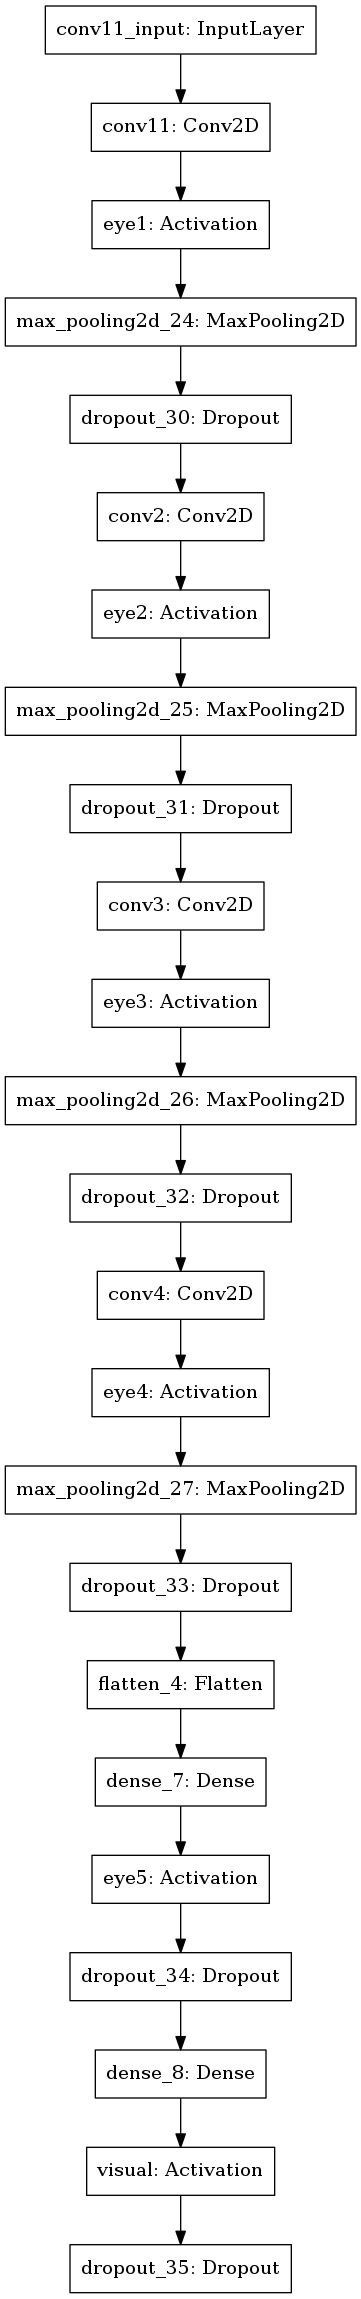

In [61]:
from IPython.display import Image
Image("model_2_lenet_1.png")